# Import libraries


In [27]:
# Import necessary libraries for data manipulation, preprocessing, modeling, and visualization

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf # For building and training LSTM models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Data loading and vizualisation

In [28]:
# Load data from CSV files and select the target column "DispFrames"
X = pd.read_csv("../data/X.csv")
Y = pd.read_csv("../data/Y.csv")["DispFrames"]

# Preprocessing: Remove TimeStamp and missing values
timestamp = X["TimeStamp"] # Store the TimeStamp column separately
X.drop(X.columns[0:2], axis=1, inplace=True) 
X.dropna(how='any', inplace=True)

# Data preparation

In [29]:
# Standardize the dataset to have zero mean and unit variance
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [30]:
# Define a function to remove outliers based on a custom threshold
def remove_outliers(X,T):
    # Identify outliers
    df = X.copy()
    outliers = (df.abs() > T).any(axis=1)
    # Remove outliers
    df_no_outliers = df[~outliers]
    return df_no_outliers, np.array(outliers)

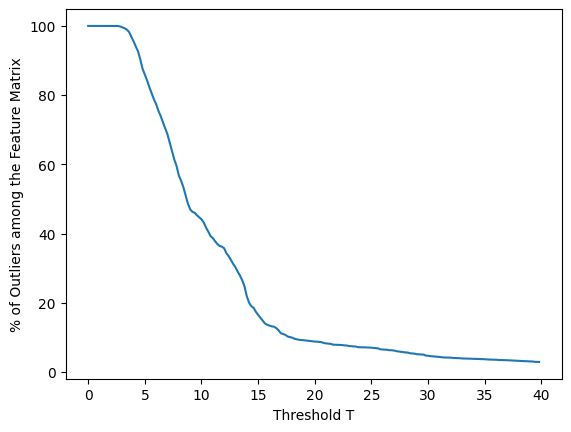

In [31]:
# Define a range of thresholds to identify the percentage of outliers in the dataset

thresholds = np.arange(0,40,0.2)
num_outliers = [] # Store the percentage of outliers for each threshold

# For each threshold, calculate the percentage of outliers removed
for T in thresholds :
  df_no_outliers,_ = remove_outliers(X,T)
  num_outliers.append((len(X) - len(df_no_outliers))*100/len(X))

# Plot the percentage of outliers removed as a function of threshold T

plt.plot(thresholds, num_outliers)
plt.xlabel('Threshold T')
plt.ylabel('% of Outliers among the Feature Matrix')
plt.show()

In [32]:
# Remove outliers : we want to keep 95% of the data, let's select T that removes 5% of outliers
num_outliers = np.array(num_outliers)
T = int(thresholds[np.argwhere(num_outliers<5)[0]])
print("The threshold is {}.".format(T))

# Remove the identified outliers from both the feature matrix and target variable
X_no_outliers, outliers = remove_outliers(X,T)
Y_no_outliers = Y[~outliers]
t_no_outliers = timestamp[~outliers]

The threshold is 29.


In [33]:
# Feature Selection
# model = RandomForestRegressor(n_estimators=50, random_state=42)
# model.fit(X_no_outliers, Y_no_outliers)
# feature_importances = model.feature_importances_

In [34]:
# Selecting top 16 features
"""best_features_idx = np.argsort(feature_importances)[-16:]  # Select top 16 features
best_features = X.columns[best_features_idx]
print('Best features', best_features)"""
#To avoid re-fitting each time
best_features = ['4_i124_intr.s', '3_ldavg.5', '4_cpu8_.sys', '3_i133_intr.s',
       '4_cpu11_.usr', '3_i126_intr.s', '4_cpu4_.usr', '4_cpu10_.idle',
       '0_kbdirty', '4_kbdirty', '4_cpu6_.sys', '4_cpu4_.sys', '4_ldavg.1',
       '4_all_..idle', '2_kbinact', '2_all_..idle']
X_selected = X_no_outliers.loc[:, best_features]

# Create a new training set and a new test set with samples of structure

In [35]:
# Train/Test Split
T = int(0.7 * len(X_selected))
X_train, X_test = X_selected.iloc[:T, :], X_selected.iloc[T:, :]
Y_train, Y_test = Y_no_outliers.iloc[:T], Y_no_outliers.iloc[T:]

# Reshaping Data for Time Series Forecasting
# Define a function to create new structured dataset
def create_dataset(X, Y, l=0, h=0,s=1):
    X_new, Y_new = [], []
    for i in range(l, len(X) - h):
        # We can use these indexes if we want to change the value of s
        #X_idx = np.arange(i-s*l,i+1,s)
        #Y_idx = np.arange(i,i+s*h+1,s)

        X_new.append(X.iloc[i-l:i+1].to_numpy().flatten())
        Y_new.append(Y.iloc[i:i+h+1].to_numpy())
        
    return np.array(X_new), np.array(Y_new)

In [36]:
# Function to build an LSTM model with squared error loss function

def build_lstm_model_squared(X,Y):
    model = Sequential(LSTM(units = 50, activation='relu', return_sequences = False, input_shape = (X.shape[1],X.shape[2])))
    model.add(Dense(Y.shape[1], activation='linear')) # Output layer with Linear activation function for Regression

    opt = tf.optimizers.Adam(learning_rate = 0.001) # Adam optimizer with a small learning rate
    model.compile(optimizer=opt, loss='mean_squared_error') # Compile the model with MSE loss
    return model

In [37]:
# Test for l = 5 and h = 1
# Creation of the LSTM model
l = 5
h = 2

X1_train,Y1_train = create_dataset(X_train,Y_train,l,h) # Prepare train set
X1_test,Y1_test = create_dataset(X_test,Y_test,l,h) # Prepare test set
X1_train = X1_train.reshape((X1_train.shape[0],l+1,X_train.shape[1])) # Reshape for LSTM input
X1_test = X1_test.reshape((X1_test.shape[0],l+1,X_test.shape[1]))

model = build_lstm_model_squared(X1_train,Y1_train) # Build the LSTM model
model.fit(X1_train, Y1_train, epochs=30, batch_size=32,validation_split = 0.2,verbose = 0) # Train the model

# Evaluate the model on the test set
predictions = model.predict(X1_test) # Generate predictions

NMAE = mean_absolute_error(Y1_test, predictions) / np.mean(np.abs(Y1_test)) # Compute Normalized Mean Absolute Error
print(NMAE)


165/165 [==============================] - 1s 2ms/step
0.1316924370203397


In [38]:
# Let's generalize it by training LSTM Models for different lags and horizons
results_squared = pd.DataFrame(index=range(11), columns=range(11))  # 11x11 table for l and h

for l in range(11):
    for h in range(11):
        X_train_new, Y_train_new = create_dataset(X_train, Y_train, l, h) # Prepare new dataset
        X_test_new, Y_test_new = create_dataset(X_test, Y_test, l, h)

        X_train_new = X_train_new.reshape((X_train_new.shape[0], l+1, X_train.shape[1])) # Reshape for LSTM
        X_test_new = X_test_new.reshape((X_test_new.shape[0], l+1, X_test.shape[1]))

        model = build_lstm_model_squared(X_train_new, Y_train_new) # Train model for current l and h
        model.fit(X_train_new, Y_train_new, epochs=30, batch_size=32,validation_split = 0.2,verbose = 0)

        Y_pred = model.predict(X_test_new) # Generate predictions

        # Predict and Evaluate
        nmae = mean_absolute_error(Y_test_new, Y_pred) / np.mean(np.abs(Y_test_new))
        results_squared.at[h, l] = nmae

# Display the results table
print(results_squared)

165/165 [==============================] - 1s 3ms/step
          0         1         2         3         4         5         6   \
0   0.185458  0.126374  0.127632  0.120519  0.146579  0.142563  0.121882   
1   0.182186  0.142054  0.138552  0.117229  0.115816  0.138097  0.133363   
2   0.181777  0.126099  0.126889  0.123062   0.11892  0.123407    0.1213   
3   0.179413  0.126438  0.128856  0.118622  0.121532   0.12332  0.135044   
4   0.173211  0.124087  0.119677  0.126023  0.123057  0.123246  0.134618   
5   0.151777  0.122542  0.115002  0.126269  0.127151  0.121049  0.126094   
6   0.157815  0.125445  0.118156  0.117881  0.123011  0.119152  0.127328   
7   0.157201  0.126449  0.122382  0.123366  0.118276  0.122571  0.116545   
8   0.157294  0.122316  0.116177  0.117503  0.122704  0.121009  0.118704   
9    0.17118  0.121731  0.120581  0.126996  0.127503  0.125533  0.127451   
10  0.170255    0.1291  0.125228  0.123459  0.126631   0.12452  0.121561   

          7         8         9 

In [48]:
from tensorflow.keras.metrics import MeanAbsolutePercentageError

# Alternative LSTM model with mean absolute error loss function
def build_lstm_model_absolute(X, Y):
    model = Sequential()
    model.add(LSTM(units = 50, activation='relu', return_sequences = False, input_shape = (X.shape[1], X.shape[2])))
    model.add(Dense(Y.shape[1], activation='linear'))  # Output layer with Linear activation function

    opt = tf.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer=opt, loss='mean_absolute_error', metrics=[MeanAbsolutePercentageError()])
    return model

In [ ]:
# Let's generalize it by training LSTM Models for different lags and horizons
results_absolute = pd.DataFrame(index=range(11), columns=range(11))  # 11x11 table for l and h

for l in range(11):
    for h in range(11):
        X_train_new, Y_train_new = create_dataset(X_train, Y_train, l, h)
        X_test_new, Y_test_new = create_dataset(X_test, Y_test, l, h)

        X_train_new = X_train_new.reshape((X_train_new.shape[0], l+1, X_train.shape[1]))
        X_test_new = X_test_new.reshape((X_test_new.shape[0], l+1, X_test.shape[1]))

        model = build_lstm_model_absolute(X_train_new, Y_train_new)
        model.fit(X_train_new, Y_train_new, epochs=30, batch_size=32,validation_split = 0.2,verbose = 0)

        Y_pred = model.predict(X_test_new)

        # Predict and Evaluate
        nmae = mean_absolute_error(Y_test_new, Y_pred) / np.mean(np.abs(Y_test_new))
        results_absolute.at[h, l] = nmae

# Display the results table
print(results_absolute)

165/165 [==============================] - 1s 4ms/step
          0         1         2         3         4         5         6   \
0   0.159695  0.107967  0.109897   0.10898  0.111332  0.115758  0.105573   
1   0.154311  0.115126   0.11173  0.116199  0.117954  0.139561  0.110044   
2    0.14219   0.11065  0.110463  0.108357  0.112747  0.110749  0.113518   
3   0.132167  0.112957  0.106571  0.113602  0.131989  0.111347  0.132644   
4   0.150016  0.112175  0.108966   0.10202  0.099803  0.111532  0.109188   
5   0.143276  0.113255  0.106959  0.099551  0.104872  0.105945  0.117105   
6   0.122656  0.110572  0.109261  0.101737  0.103727  0.110921  0.109875   
7   0.132159   0.10654  0.107761  0.102299   0.10687  0.105248  0.100032   
8   0.140647  0.107316  0.105936  0.111668  0.107138  0.107732  0.110192   
9   0.131029  0.105477  0.106654  0.107851  0.108918  0.103643  0.105598   
10  0.127258  0.106437  0.107401  0.107102  0.102988  0.103592  0.100023   

          7         8         9 